# **Aprendizaje supervisado**
# SL10. Random forest

Echaremos un vistazo a la motivación de un poderoso algoritmo: un algoritmo no paramétrico llamado **Random Forest**.
Random Forest es un ejemplo de un método de **ensamblado** , lo que significa que se basa en la agregación de los resultados de un conjunto de estimadores más simples.
El resultado algo sorprendente con tales métodos de conjunto es que la suma puede ser mayor que las partes: es decir, ¡un voto mayoritario entre varios estimadores puede terminar siendo mejor que cualquiera de los estimadores individuales que votan!
Veremos ejemplos de esto en las siguientes secciones.
Comenzamos con las importaciones estándar:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## <font color='blue'>**Random Forest**</font>

Random forest es un ejemplo de un **ensamblado** construido sobre árboles de decisión.
Por esta razón, comenzaremos discutiendo los propios árboles de decisión.

1. Los árboles de decisión a menudo imitan el pensamiento a nivel humano, por lo que es muy sencillo comprender los datos y hacer algunas buenas interpretaciones.

2. Los árboles de decisión le hacen ver la lógica de los datos a interpretar (no como los algoritmos de caja negra como SVM, ANN, etc.).

3. Un árbol de decisión es un árbol donde cada nodo representa una característica (atributo), cada vínculo (rama) representa una decisión (regla) y cada hoja representa un resultado (valor categórico o continuo).

Los árboles de decisión son formas extremadamente intuitivas de clasificar o etiquetar objetos: simplemente haga una serie de preguntas diseñadas para concentrarse en la clasificación.
Por ejemplo, si quisiera construir un árbol de decisiones para clasificar un animal con el que se encuentra durante una caminata, puede construir el que se muestra aquí:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree.png?raw=1)

La división binaria hace que esto sea extremadamente eficiente: en un árbol bien construido, cada pregunta reducirá el número de opciones a aproximadamente la mitad, reduciendo muy rápidamente las opciones incluso entre un gran número de clases.
El truco, por supuesto, está en decidir qué preguntas hacer en cada paso.
En las implementaciones de aprendizaje automático de árboles de decisión, las preguntas generalmente toman la forma de divisiones alineadas con el eje en los datos: es decir, cada nodo del árbol divide los datos en dos grupos utilizando un valor de corte dentro de una de las características.
Veamos ahora un ejemplo de esto.

## Creando Árboles de Decisión

Considere los siguientes datos bidimensionales, que tienen una de cuatro etiquetas de clase:

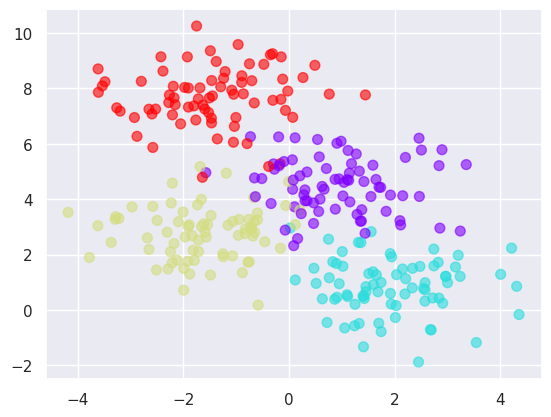

In [12]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', alpha=0.6)
plt.show()

Un árbol de decisión simple construido sobre estos datos dividirá iterativamente los datos a lo largo de uno u otro eje de acuerdo con algún criterio cuantitativo, y en cada nivel asignará la etiqueta de la nueva región de acuerdo con un voto mayoritario de puntos dentro de ella.
Esta figura presenta una visualización de los primeros cuatro niveles de un clasificador de árbol de decisión para estos datos:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-levels.png?raw=1)

Observe que después de la primera división, todos los puntos de la rama superior permanecen sin cambios, por lo que no es necesario subdividir más esta rama.
A excepción de los nodos que contienen todos de un color, en cada nivel cada región se divide nuevamente a lo largo de una de las dos características.

Este proceso de ajustar un árbol de decisiones a nuestros datos se puede realizar en Scikit-Learn con el estimador `` DecisionTreeClassifier '':

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Escribamos una función de utilidad rápida para ayudarnos a visualizar la salida del clasificador:

In [4]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap,
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Ahora podemos examinar cómo se ve la clasificación del árbol de decisión:

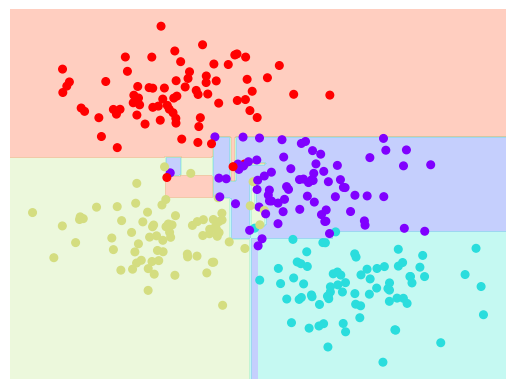

In [5]:
visualize_classifier(DecisionTreeClassifier(), X, y)

Observe que a medida que aumenta la profundidad, tendemos a obtener regiones de clasificación de formas muy extrañas; por ejemplo, a una profundidad de cinco, hay una región púrpura alta y delgada entre las regiones amarilla y azul.
Está claro que esto es menos un resultado de la verdadera distribución intrínseca de los datos y más un resultado de las propiedades particulares de muestreo o ruido de los datos.
Es decir, este árbol de decisiones, incluso a solo cinco niveles de profundidad, claramente sobrepasa nuestros datos.

## Árboles de Decisión y Overfitting

Tal sobreajuste resulta ser una propiedad general de los árboles de decisión: es muy fácil profundizar demasiado en el árbol y, por lo tanto, ajustar los detalles de los datos particulares en lugar de las propiedades generales de las distribuciones de las que se extraen.
Otra forma de ver este ajuste excesivo es observar modelos entrenados en diferentes subconjuntos de datos; por ejemplo, en esta figura entrenamos dos árboles diferentes, cada uno en la mitad de los datos originales:

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.08-decision-tree-overfitting.png?raw=1)

Está claro que en algunos lugares, los dos árboles producen resultados consistentes (por ejemplo, en las cuatro esquinas), mientras que en otros lugares, los dos árboles dan clasificaciones muy diferentes (por ejemplo, en las regiones entre dos grupos).
La observación clave es que las inconsistencias tienden a ocurrir donde la clasificación es menos segura y, por lo tanto, al usar información de * ambos * de estos árboles, ¡podríamos obtener un mejor resultado!

Si está ejecutando este cuaderno en vivo, la siguiente función le permitirá mostrar interactivamente los ajustes de árboles entrenados en un subconjunto aleatorio de los datos:

Así como el uso de información de dos árboles mejora nuestros resultados, podríamos esperar que el uso de información de muchos árboles mejore nuestros resultados aún más.

## Algoritmos

1. __CART__ (árboles de clasificación y regresión) → utiliza el índice de Gini (clasificación) como métrica.

2. __ID3__ (dicotomizador iterativo 3) → utiliza la función de entropía y la ganancia de información como métricas.

**Entropía:** La entropía de un conjunto de datos, es una medida de la impureza o desorden, del conjunto de datos. La entropía también puede pensarse, como una medida de incertidumbre. Siempre deberíamos intentar minimizar la entropía.

**Ganancia de información:** La ganancia de información es una medida de cuánta información nos brinda una característica sobre las clases. El algoritmo de árboles de decisión siempre intentará maximizar la ganancia de información. La característica que divide perfectamente los datos, debe dar la máxima información.

**Indice de Gini:** El índice de Gini, también conocido como impureza de Gini, es una medida de entropía y calcula la probabilidad de que un elemento pertenezca a una categoria.

## <font color='green'>Actividad 1</font>

Construya un arbol de decisión con los datos proporcionados e interprete este. Apóyese en los códigos siguientes.



```
from sklearn.tree import DecisionTreeClassifier
```

Considere utilizar variables dummy para poder realizar la separación.



```
one_hot_data = pd.get_dummies
```

Y utilice el siguiente código para visualizar el resultado del arbol.



```
# Export/Print un arbol de decisión en formato .dot.
print(tree.export_graphviz(clf_train, None))

# Crea la data.
dot_data = tree.export_graphviz(clf_train, out_file=None, feature_names=list(one_hot_data.columns.values),
                                class_names=['Not_Play', 'Play'], rounded=True, filled=True) #Gini o Entropia.
#Creaamos el grafico.
graph = pydotplus.graph_from_dot_data(dot_data)

# Mostramos el gráfico.
Image(graph.create_png())
```



In [6]:
## importemos dependencias
from sklearn import tree
import pandas as pd
import pydotplus
from IPython.display import Image


In [7]:
# Creemos el dataset

golf_df = pd.DataFrame()

#agreguemos outlook
golf_df['Outlook'] = ['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy',
                     'overcast', 'sunny', 'sunny', 'rainy', 'sunny', 'overcast',
                     'overcast', 'rainy']

#agreguemos temperature
golf_df['Temperature'] = ['hot', 'hot', 'hot', 'mild', 'cool', 'cool', 'cool',
                         'mild', 'cool', 'mild', 'mild', 'mild', 'hot', 'mild']

#agreguemos humidity
golf_df['Humidity'] = ['high', 'high', 'high', 'high', 'normal', 'normal', 'normal',
                      'high', 'normal', 'normal', 'normal', 'high', 'normal', 'high']

#agreguemos windy
golf_df['Windy'] = ['false', 'true', 'false', 'false', 'false', 'true', 'true',
                   'false', 'false', 'false', 'true', 'true', 'false', 'true']

#Se juega o no play?
golf_df['Play'] = ['no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes',
                  'yes', 'yes', 'no']


#Print/show the new data
print(golf_df)

     Outlook Temperature Humidity  Windy Play
0      sunny         hot     high  false   no
1      sunny         hot     high   true   no
2   overcast         hot     high  false  yes
3      rainy        mild     high  false  yes
4      rainy        cool   normal  false  yes
5      rainy        cool   normal   true   no
6   overcast        cool   normal   true  yes
7      sunny        mild     high  false   no
8      sunny        cool   normal  false  yes
9      rainy        mild   normal  false  yes
10     sunny        mild   normal   true  yes
11  overcast        mild     high   true  yes
12  overcast         hot   normal  false  yes
13     rainy        mild     high   true   no


In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image

# Creación del DataFrame
golf_df = pd.DataFrame({
    'Outlook': ['sunny', 'sunny', 'overcast', 'rainy', 'rainy', 'rainy',
                'overcast', 'sunny', 'sunny', 'rainy', 'sunny', 'overcast',
                'overcast', 'rainy'],
    'Temperature': ['hot', 'hot', 'hot', 'mild', 'cool', 'cool',
                    'cool', 'mild', 'cool', 'mild', 'mild', 'mild',
                    'hot', 'mild'],
    'Humidity': ['high', 'high', 'high', 'high', 'normal', 'normal',
                 'normal', 'high', 'normal', 'normal', 'normal', 'high',
                 'normal', 'high'],
    'Wind': ['weak', 'strong', 'weak', 'weak', 'weak', 'strong',
             'strong', 'weak', 'weak', 'weak', 'strong', 'strong',
             'weak', 'strong'],
    'Play': ['Not_Play', 'Not_Play', 'Play', 'Play', 'Play', 'Not_Play',
             'Play', 'Not_Play', 'Play', 'Play', 'Play', 'Play', 'Play', 'Not_Play']
})

# Conversión de variables categóricas en variables dummy
one_hot_data = pd.get_dummies(golf_df[['Outlook', 'Temperature', 'Humidity', 'Wind']])
# Variable objetivo
y = golf_df['Play']


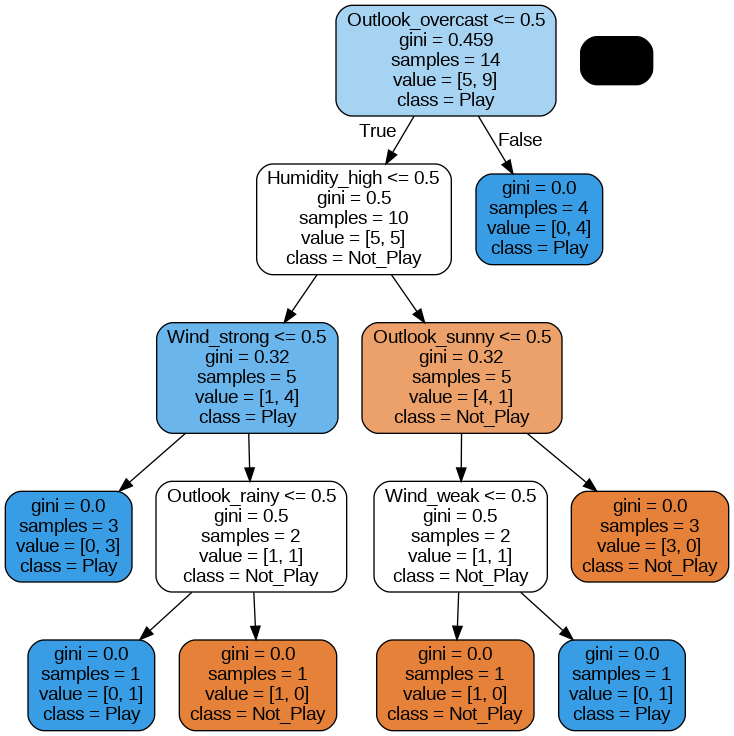

In [9]:
# Tú codigo aquí

# Crear y entrenar el árbol de decisión
clf_train = DecisionTreeClassifier(criterion='gini')
clf_train = clf_train.fit(one_hot_data, y)


# Exportar el árbol a formato .dot y crear el gráfico
dot_data = export_graphviz(clf_train, out_file=None,
                           feature_names=list(one_hot_data.columns.values),
                           class_names=['Not_Play', 'Play'],
                           rounded=True, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


<font color='green'>Fin Actividad 1</font>

## <font color='blue'>**Ensamblado de Estimadores: Random Forest**</font>

Ensemble es un concepto de Machine Learning en el que la idea es entrenar múltiples modelos utilizando el mismo algoritmo de aprendizaje. Los conjuntos participan en un grupo más grande de métodos, llamados multiclasificadores, donde un conjunto de cientos o miles de modelos con un objetivo común se fusionan para resolver el problema.

Las principales causas de error en el aprendizaje se deben al ruido, el Bias y el variance. EL Ensemble ayuda a minimizar estos factores. Estos métodos están diseñados para mejorar la estabilidad y precisión de los algoritmos de aprendizaje automático. Las combinaciones de múltiples clasificadores disminuyen la varianza, especialmente en el caso de clasificadores inestables, y pueden producir una clasificación más confiable que un solo clasificador.

1. En un Bagging y Boosting, tenemos N weak learners. Bagging and Boosting consigue N learners al generar datos adicionales en la etapa de entrenamiento. Se producen N nuevos conjuntos de datos de entrenamiento mediante un muestreo aleatorio con reemplazo del conjunto original. Al muestrear con reemplazo, algunas observaciones pueden repetirse en cada nuevo conjunto de datos de entrenamiento.

2. En el caso del bagging, cualquier elemento tiene la misma probabilidad de aparecer en un nuevo conjunto de datos. Sin embargo, para Boosting las observaciones están ponderadas y, por lo tanto, algunas de ellas participarán en los nuevos conjuntos con más frecuencia:

3. En este punto, comenzamos a abordar la principal diferencia entre los dos métodos. Si bien la etapa de entrenamiento es paralela para Bagging (es decir, cada modelo se construye de forma independiente), Boosting construye al nuevo alumno de forma secuencial.

<img src="https://drive.google.com/uc?export=view&id=1TanR7P_KMlg1egHqzm0GcQInjRL8rXPM" float="left" title="Bagging Boosting differences" />

En los algoritmos boosting, cada clasificador se entrena con datos, teniendo en cuenta el resultado de los clasificadores anteriores. Después de cada paso de entrenamiento, los pesos se redistribuyen. Los datos mal clasificados aumentan su ponderación para enfatizar los casos más difíciles. De esta forma, los learners posteriores se centrarán en ellos durante su entrenamiento.

4. Para predecir la clase de nuevos datos, solo necesitamos aplicar los N learners a las nuevas observaciones. En Bagging, el resultado se obtiene promediando las respuestas de los N learners (o el voto de la mayoría). Sin embargo, Boosting asigna un segundo conjunto de ponderaciones, esta vez para los clasificadores N, con el fin de obtener un promedio ponderado de sus estimaciones. En la etapa de entrenamiento Boosting, el algoritmo asigna pesos a cada modelo resultante. A un learners con un buen resultado de clasificación en los datos de entrenamiento se le asignará un peso más alto que a uno deficiente. Por lo tanto, al evaluar a un nuevo learners, Boosting también debe realizar un seguimiento de los errores de los learners.




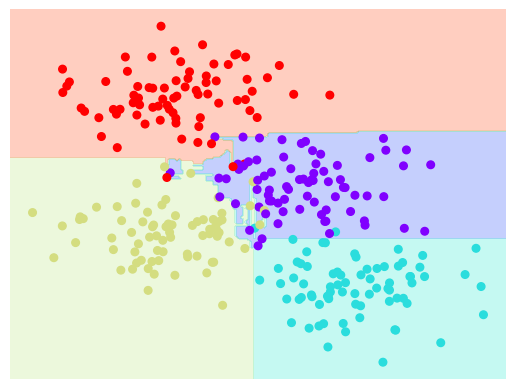

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier # Usa muestreo boostrap

tree = DecisionTreeClassifier() # Learner
bag = BaggingClassifier(tree,
                        n_estimators=100,
                        max_samples=0.8, # Le pasamos los learners
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

En este ejemplo, hemos aleatorizado los datos ajustando cada estimador con un subconjunto aleatorio del 80% de los puntos de entrenamiento.
En la práctica, los árboles de decisión se aleatorizan de manera más efectiva inyectando algo de estocasticidad en la forma en que se eligen las divisiones: de esta manera, todos los datos contribuyen al ajuste cada vez, pero los resultados del ajuste aún tienen la aleatoriedad deseada.
Por ejemplo, al determinar qué característica dividir, el árbol aleatorio puede seleccionar entre las principales características.
Puede leer más detalles técnicos sobre estas estrategias de aleatorización en la [documentación de Scikit-Learn](http://scikit-learn.org/stable/modules/ensemble.html#forest) y en las referencias.

En Scikit-Learn, este conjunto optimizado de árboles de decisión aleatorios se implementa en el estimador `RandomForestClassifier`, que se encarga de toda la aleatorización automáticamente.
Todo lo que necesita hacer es seleccionar una serie de estimadores, y muy rápidamente (en paralelo, si lo desea) se ajustará al conjunto de árboles:

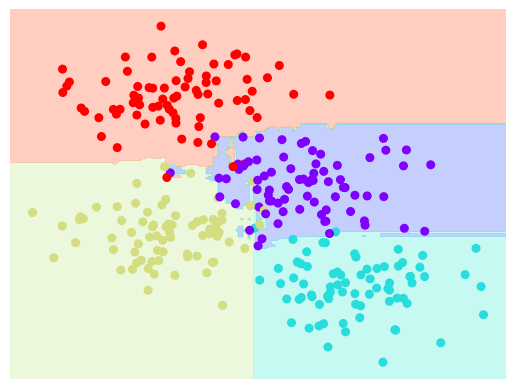

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

Vemos que al promediar más de 100 modelos perturbados aleatoriamente, terminamos con un modelo general que está mucho más cerca de nuestra intuición sobre cómo se debe dividir el espacio de parámetros.

## Random Forest para Regressión

En la sección anterior consideramos los random forest dentro del contexto de la clasificación.
Random forest también pueden funcionar en el caso de regresión (es decir, variables continuas en lugar de categóricas). El estimador a utilizar para esto es el `RandomForestRegressor`, y la sintaxis es muy similar a la que vimos anteriormente.

Considere los siguientes datos, extraídos de la combinación de una oscilación rápida y lenta:

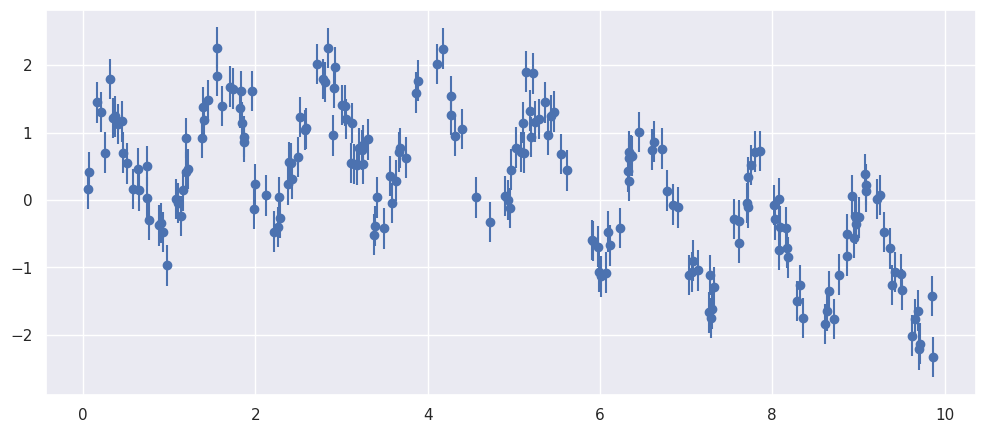

In [15]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.figure(figsize=(12, 5))
plt.errorbar(x, y, 0.3, fmt='o')
plt.show()

Usando el regresor de random forest, podemos encontrar la curva de mejor ajuste de la siguiente manera:

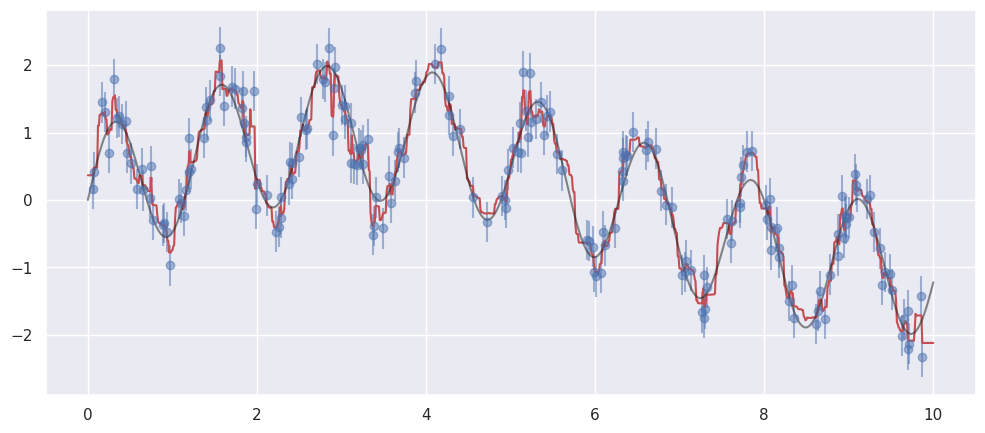

In [16]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.figure(figsize=(12, 5))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, 'r'); # Este es el fit
plt.plot(xfit, ytrue, '-k', alpha=0.5);  # y este es el original
plt.show()

Aquí, el modelo real se muestra en la curva gris suave, mientras que el modelo de random forest se muestra en la curva roja irregular.
Como puede ver, el modelo de random forest no paramétrico es lo suficientemente flexible como para ajustarse a los datos de períodos múltiples, ¡sin que tengamos que especificar un modelo de períodos múltiples!

## <font color='green'>Actividad 2</font>

Clasificación de digitos. Esta actividad tiene por objetivo implementar un clasificador de digitos escritos a mano utilizando random forest.

1. Explore el data se y visualice datos. Puede utilizar el siguiente código para ver las imagenes. ¿Cuales son las dimensiones de la imágen?, ¿Entre que valores se mueve?

```
ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
```
2. Entrene un clasificador utilizando **RandomForestClassifier**. Explore algunos parámetros como por ejemplo.

* __max_depth__: La profundidad máxima del árbol. Si es None, los nodos se expanden hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos de min_samples_split muestras.

* __n_estimators__: La cantidad de árboles a considerar.

* __max_features__: La cantidad de características que se deben considerar al buscar la mejor división:
<br>

3. Evalue los resultados a través de una matriz de confusión y ponga el resultado de una mariz en un heatmap para una mejor visualización.


In [20]:
# Cargando y visualizando el dataset.
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

Para recordarnos lo que estamos viendo, visualizaremos los primeros puntos de datos:

Keys del dataset: dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
Dimensión de las imágenes: (1797, 8, 8)
Rango de valores de píxeles: (np.float64(0.0), np.float64(16.0))


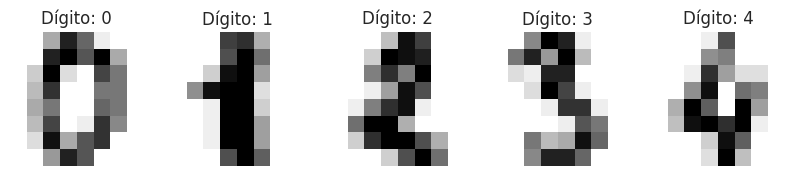

Exactitud del modelo: 0.9778


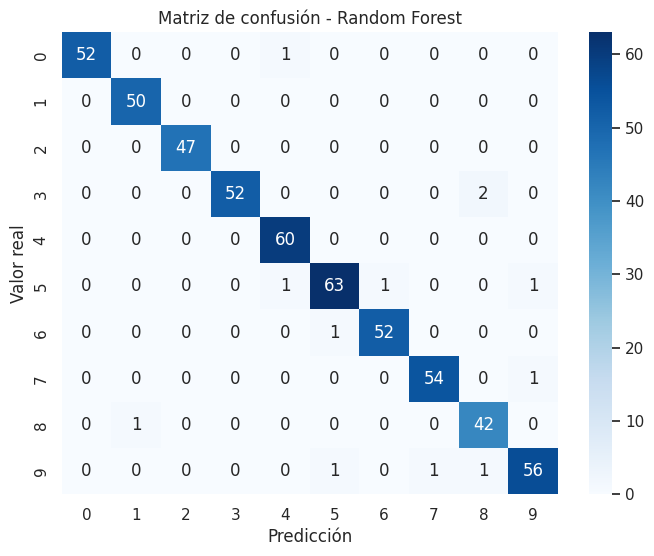

In [17]:
# Tú codigo aquí


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Cargar el dataset de dígitos
digits = load_digits()

# Mostrar la estructura del dataset
print("Keys del dataset:", digits.keys())
print("Dimensión de las imágenes:", digits.images.shape)  # (1797, 8, 8)
print("Rango de valores de píxeles:", (digits.images.min(), digits.images.max()))  # (0, 16)

# Visualizar algunas imágenes de dígitos
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    ax.set_title(f"Dígito: {digits.target[i]}")
    ax.axis("off")
plt.show()

# Preparar datos para el entrenamiento
X = digits.data  # Convertir imágenes 8x8 en vectores de 64 elementos
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar un clasificador Random Forest
clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', random_state=42)
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Evaluar resultados
acc = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {acc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=digits.target_names, yticklabels=digits.target_names)
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de confusión - Random Forest")
plt.show()

<font color='green'>Fin Actividad 2</font>

## Resumen del Método Random Forest:

Esta sección contiene una breve introducción al concepto de *ensamblados*, y en particular random forest, un conjunto de árboles de decisión aleatorios.
Random Forest es un método poderoso con varias ventajas:

- Tanto el entrenamiento como la predicción son muy rápidos, debido a la simplicidad de los árboles de decisión subyacentes. Además, ambas tareas se pueden paralelizar directamente, porque los árboles individuales son entidades completamente independientes.
- Los árboles múltiples permiten una clasificación probabilística: un voto mayoritario entre los estimadores da una estimación de la probabilidad (se accede en Scikit-Learn con el método `predict_proba()`).
- El modelo no paramétrico es extremadamente flexible y, por lo tanto, puede funcionar bien en tareas que no están ajustadas por otros estimadores.

Una desventaja principal de Random Forest es que los resultados no se pueden interpretar fácilmente: es decir, si desea sacar conclusiones sobre el *significado* del modelo de clasificación,  Random Forest pueden no ser la mejor opción.

# <font color='purple' style='bold' size=5>**EXPERIMENTO** </font>

Mostraremos cómo la importancia de las características cambia cuando se aplica ingeniería de características en un conjunto de datos.

Dataset: Usaremos el conjunto de datos de diabetes de sklearn.datasets, que contiene variables clínicas y mediciones de pacientes.


Entrenaremos un Random Forest con los datos originales.

Aplicaremos ingeniería de características (creación de nuevas variables).

Entrenaremos un nuevo modelo con las características mejoradas.

Compararemos la importancia de las características antes y después.

Error cuadrático medio (MSE) del modelo original: 2952.0106
Error cuadrático medio (MSE) con nuevas características: 2959.1989


<ipython-input-18-ec71eef36719>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_original, y=X.columns[:-2], palette="Blues")
<ipython-input-18-ec71eef36719>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_new, y=X.columns, palette="Greens")


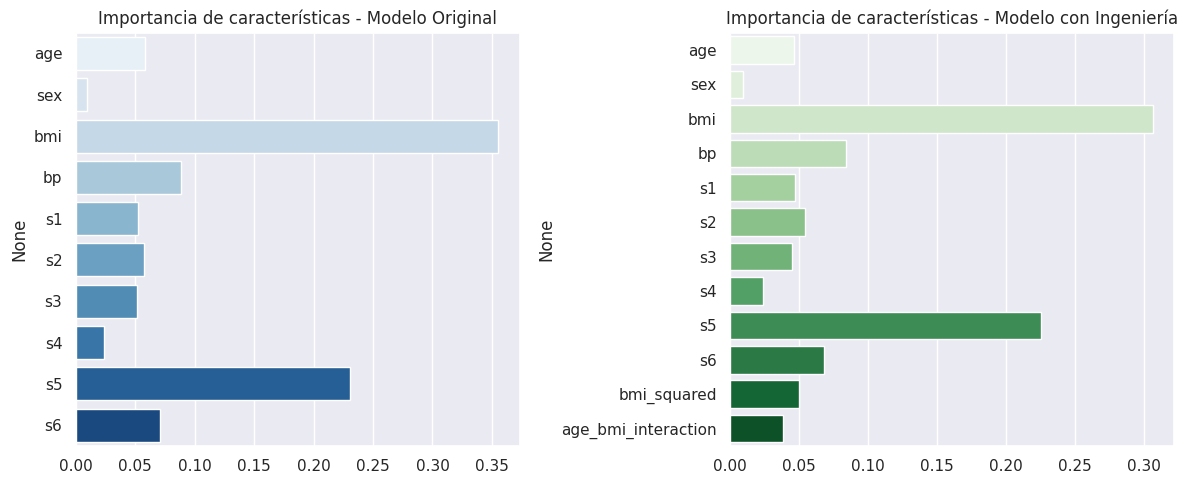

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Cargar datos de diabetes
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target  # Variable objetivo

# Separar datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar Random Forest sin ingeniería de características
rf_original = RandomForestRegressor(n_estimators=100, random_state=42)
rf_original.fit(X_train, y_train)

# Evaluar el modelo original
y_pred_original = rf_original.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred_original)
print(f"Error cuadrático medio (MSE) del modelo original: {mse_original:.4f}")

# Importancia de características original
importances_original = rf_original.feature_importances_

#Ingeniería de características: Agregamos nuevas variables
X["bmi_squared"] = X["bmi"] ** 2  # Cuadrado del índice de masa corporal
X["age_bmi_interaction"] = X["age"] * X["bmi"]  # Interacción entre edad y BMI

# Volvemos a dividir los datos con las nuevas variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar Random Forest con nuevas características
rf_new = RandomForestRegressor(n_estimators=100, random_state=42)
rf_new.fit(X_train, y_train)

# Evaluar el nuevo modelo
y_pred_new = rf_new.predict(X_test)
mse_new = mean_squared_error(y_test, y_pred_new)
print(f"Error cuadrático medio (MSE) con nuevas características: {mse_new:.4f}")

# Importancia de características con nuevas variables
importances_new = rf_new.feature_importances_

# Comparación de la importancia de las características
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
sns.barplot(x=importances_original, y=X.columns[:-2], palette="Blues")
ax.set_title("Importancia de características - Modelo Original")

ax = plt.subplot(1, 2, 2)
sns.barplot(x=importances_new, y=X.columns, palette="Greens")
ax.set_title("Importancia de características - Modelo con Ingeniería")

plt.tight_layout()
plt.show()


El error cuadrático medio (MSE) debe disminuir con las nuevas variables.
Algunas variables originales serán menos importantes, y las nuevas características (como bmi_squared) tomarán más peso.
Los gráficos comparan cómo el modelo valora cada variable antes y después de mejorar los datos.

# <font color='purple' style='bold' size=5>**FIN EXPERIMENTO** </font>

# <font color='purple' style='bold' size=5>**MATERIAL ADICIONAL** </font>

**Curiosidades y Datos Interesantes**

**Estimación OOB (Out-of-Bag):**
Cada árbol utiliza aproximadamente el 63% de las muestras para el entrenamiento; las restantes, no vistas por ese árbol, se pueden usar para evaluar su desempeño de manera interna. Esto elimina la necesidad de una validación cruzada externa en muchos casos.

**Interpretabilidad:**
A pesar de ser un modelo "black-box", Random Forest ofrece métricas de importancia de características que ayudan a entender qué variables están influyendo más en las predicciones.

**Uso en diferentes campos:**
Random Forest se aplica en áreas tan diversas como la medicina, la bioinformática, la ecología y la detección de fraudes, gracias a su versatilidad y capacidad para manejar tanto variables numéricas como categóricas.

**Hiperparámetros clave:**
Algunos de los hiperparámetros más importantes incluyen:

n_estimators: Número de árboles en el bosque.

max_depth: Profundidad máxima de cada árbol.

max_features: Número de características consideradas para la mejor división en cada nodo.

oob_score: Si se activa, permite calcular la precisión utilizando muestras out-of-bag.

Otros estudios, como los de Probst et al. (2019) [​], han explorado métodos para optimizar la selección de hiperparámetros y han mostrado que la configuración óptima puede variar significativamente según el problema.

**Ejemplo de Código en Python:**

**Uso de OOB y Análisis de Importancia de Características**

En este ejemplo se utiliza el dataset de dígitos de sklearn.datasets para entrenar un clasificador Random Forest, se calcula la puntuación OOB y se visualiza la importancia de cada característica.

Exactitud en Test: 0.9759
Exactitud OOB: 0.9698


<ipython-input-19-9355a1753a7b>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=features, palette="viridis")


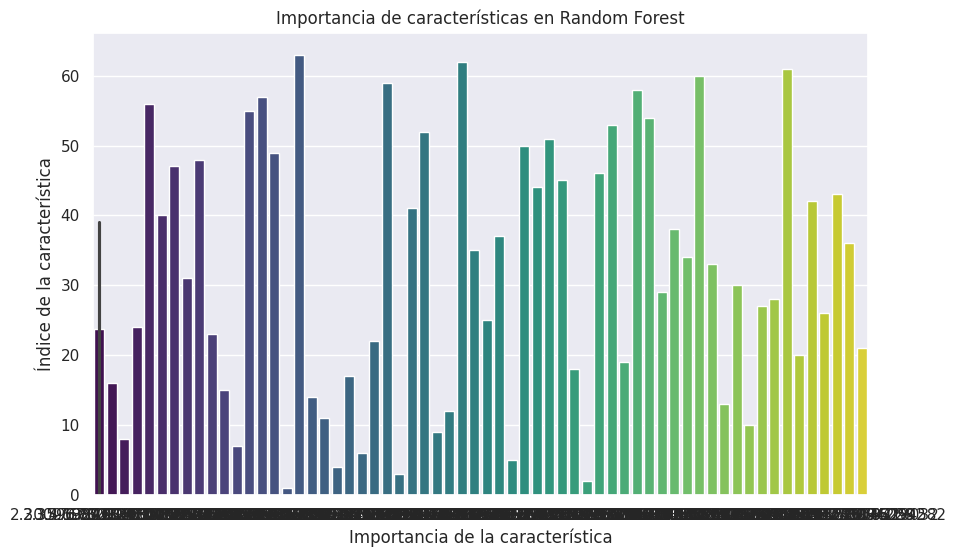

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Cargar el dataset de dígitos
digits = load_digits()
X = digits.data  # Cada imagen se transforma en un vector de 64 características
y = digits.target

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar Random Forest con OOB habilitado
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud en Test: {accuracy:.4f}")

# Puntuación Out-of-Bag
print(f"Exactitud OOB: {rf.oob_score_:.4f}")

# Visualizar la importancia de las características
feature_importances = rf.feature_importances_
features = np.arange(X.shape[1])
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, palette="viridis")
plt.xlabel("Importancia de la característica")
plt.ylabel("Índice de la característica")
plt.title("Importancia de características en Random Forest")
plt.show()


**Referencias Bibliográficas**

Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5-32.

Probst, P., Boulesteix, A.-L., & Bischl, B. (2019). Tunability: Importance of Hyperparameters of Machine Learning Algorithms. Journal of Machine Learning Research.

Documentación de Scikit-learn Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# <font color='purple' style='bold' size=5>**FIN MATERIAL ADICIONAL** </font>